In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

In [3]:
from patrec.utils import plot_series
from patrec.utils.files_helper import JSON_Handler, YAML_Config
from patrec.utils.mlflow_exp import MLflow_Experiment_Logger
import mlflow

import matplotlib.pyplot as plt

# mlflow server --backend-store-uri ".backend" --default-artifact-root ".artifacts" --host localhost --port 5000

# data generation

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

# Generate 6 time-series (3 stationary, 3 non-stationary)
n_samples = 1000

# Stationary Series
ar1 = ArmaProcess(ar=[1, -0.7]).generate_sample(n_samples)  # AR(1), phi=0.7
white_noise = np.random.normal(0, 1, n_samples)             # Pure noise
mean_reverting = 0.5 * np.sin(np.arange(n_samples) * 0.1) + np.random.normal(0, 0.1, n_samples)

# Non-Stationary Series
random_walk = np.cumsum(np.random.normal(0, 1, n_samples))  # Unit root
trend = 0.05 * np.arange(n_samples) + np.random.normal(0, 1, n_samples)  # Trend + noise
seas_comp = 120
seasonal_nonstat = 2 * np.sin(2 * np.pi * np.arange(n_samples) / seas_comp) + 0.1 * np.arange(n_samples) + np.random.normal(0, 1, n_samples)

series = {
    "AR(1) Stationary": ar1,
    "White Noise": white_noise,
    "Mean-Reverting": mean_reverting,
    "Random Walk": random_walk,
    "Trend + Noise": trend,
    "Seasonal + Drift": seasonal_nonstat
}

# check stationary + noiseness

In [ ]:
def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

def test_stationarity(ts):
    adf_p = adfuller(ts)[1]  # Null: Non-stationary
    kpss_p = kpss(ts)[1]     # Null: Stationary
    hurst = hurst_exponent(ts)
    est_stationary = (0.45 <= hurst <= 0.55) & (adf_p <= 0.05) & (kpss_p <= 0.05)
    return est_stationary, {
        "ADF p-value": adf_p,
        "KPSS p-value": kpss_p,
        "Hurst Exponent": hurst
    }

def dft_extract(data, n_freqs, fs=None, n=None, min_freq = None, max_freq = None, min_power_ratio = 1):
    
    if fs is None:
        fs = data.shape[0]
    if n is None:
        n = data.shape[0]
    
    # Compute DFT
    dft = np.fft.fft(data)
    magnitude = np.abs(dft)
    power = magnitude ** 2
    freq = np.fft.fftfreq(n, d=1/fs)

    # Filter frequencies by specified range
    pos_mask = freq > 0
    if min_freq is not None:
        pos_mask &= (freq >= min_freq)
    if max_freq is not None:
        pos_mask &= (freq <= max_freq)
        
    pos_freq = freq[pos_mask]
    pos_power = power[pos_mask]

    # Auto-select number of frequencies
    if n_freqs == 'auto':
        total_power = np.sum(pos_power)
        sorted_idx = np.argsort(pos_power)[::-1]
        cum_power = np.cumsum(pos_power[sorted_idx]) / total_power
        n_freqs = np.argmax(cum_power > min_power_ratio) + 1
    else:
        n_freqs = min(n_freqs, len(pos_freq))
        
    # Select most significant frequencies
    significant_idx = np.argpartition(pos_power, -n_freqs)[-n_freqs:]

    # Get the actual frequency indices in the original array
    original_indices = np.where(pos_mask)[0][significant_idx]

    # Reconstruct seasonal component
    reconstructed = np.zeros(n, dtype=complex)
    for idx in original_indices:
        freq_val = freq[idx]
        # Add positive frequency component
        reconstructed += (dft[idx] * np.exp(2j * np.pi * freq_val * np.arange(n) / n)) / n
        # Add negative frequency component (complex conjugate symmetric)
        if freq_val != 0 and freq_val != fs/2:
            neg_idx = n - idx 
            reconstructed += (dft[neg_idx] * np.exp(2j * np.pi * freq[neg_idx] * np.arange(n) / n)) / n

    seasonal = np.real(reconstructed)
    return seasonal

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def test_noiseness(ts, n_freqs):
    dft_est = dft_extract(ts, n_freqs)
    return np.min([mean_squared_error(ts, dft_est), mean_squared_error(ts-ts.min(), dft_est)]), dft_est

In [ ]:
ts = series['Seasonal + Drift']
n_freqs = 200
dft_est = dft_extract(ts, n_freqs)

plot_series([dft_est,ts-ts.mean()])

In [ ]:
for k, v in series.items():
    for i in [10, 50, 200, 500]:
        print(test_noiseness(v, i)[0])        

In [ ]:
series.keys()
# 

In [ ]:
# plot_series([v for k,v in series.items()], [k for k,v in series.items()], save_path='.temp/stats_for_algo_testing/pics/original_data.png')
plot_series([v for k,v in series.items()], [k for k,v in series.items()])

# Summary 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 1, 1000)  # Time from 0 to 1 sec
x = np.sin(2 * np.pi * 5 * t)  # 5 Hz sine wave

# Compute Fourier Transform
fft_x = np.fft.fft(x)
freqs = np.fft.fftfreq(len(t), t[1] - t[0])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t, x)
plt.title("Time Domain (5 Hz Sine Wave)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(freqs[:len(freqs)//2], np.abs(fft_x[:len(fft_x)//2])**2)  # Power spectrum (positive freqs)
plt.title("Frequency Domain (Power Spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim(0, 10)
plt.show()

In [ ]:
np.random.seed(0)
t = np.linspace(0, 1, 1000)
x_clean = np.sin(2 * np.pi * 3 * t) + 0.5 * np.sin(2 * np.pi * 8 * t)
x_noisy = x_clean + 0.5 * np.random.randn(len(t))  # Add Gaussian noise

fft_noisy = np.fft.fft(x_noisy)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t, x_noisy)
plt.title("Time Domain (Noisy Signal)")
plt.xlabel("Time (s)")

plt.subplot(122)
plt.plot(freqs[:len(freqs)//2], np.abs(fft_noisy[:len(fft_noisy)//2])**2)
plt.title("Frequency Domain (Power Spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim(0, 15)
plt.show()

In [ ]:
# Generate noisy signal (3 Hz + 8 Hz + noise)
np.random.seed(0)
t = np.linspace(0, 1, 1000)
x_clean = np.sin(2 * np.pi * 3 * t) + 0.5 * np.sin(2 * np.pi * 8 * t)
x_noisy = x_clean + 0.5 * np.random.randn(len(t))  # Add noise

# Compute FFT and power spectrum
fft_noisy = np.fft.fft(x_noisy)
power = np.abs(fft_noisy)**2
freqs = np.fft.fftfreq(len(t), t[1] - t[0])

# Find median power (noise threshold)
median_power = np.median(power)

# Zero out frequencies below median power (noise removal)
fft_denoised = fft_noisy.copy()
fft_denoised[power < median_power] = 0  # Remove weak frequencies

# Reconstruct denoised signal
x_denoised = np.fft.ifft(fft_denoised).real  # Take real part to remove small imaginary artifacts

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.plot(t, x_noisy, label="Noisy Signal", alpha=0.7)
plt.title("Original Noisy Signal")
plt.xlabel("Time (s)")

plt.subplot(222)
plt.plot(freqs[:len(freqs)//2], power[:len(power)//2], label="Power Spectrum")
plt.axhline(median_power, color='r', linestyle='--', label="Median Power")
plt.title("Power Spectrum (Noisy)")
plt.xlabel("Frequency (Hz)")
plt.legend()

plt.subplot(223)
plt.plot(t, x_denoised - x_clean, 'g', label="Denoised Signal", linewidth=2)
plt.title("Denoised Signal (Median Power Threshold)")
plt.xlabel("Time (s)")

plt.subplot(224)
plt.plot(freqs[:len(freqs)//2], np.abs(fft_denoised[:len(fft_denoised)//2])**2, 'orange')
plt.title("Power Spectrum (Denoised)")
plt.xlabel("Frequency (Hz)")


plt.tight_layout()
plt.show()

In [ ]:
def reconstruct_top_n(x, top_n=2):
    fft_x = np.fft.fft(x)
    power = np.abs(fft_x)**2
    freqs = np.fft.fftfreq(len(x), t[1] - t[0])
    
    # Find indices of top N frequencies
    top_indices = np.argsort(power)[-top_n*2:]  # *2 to account for negative frequencies
    fft_reconstructed = np.zeros_like(fft_x)
    fft_reconstructed[top_indices] = fft_x[top_indices]  # Keep only top frequencies
    
    # Reconstruct signal
    x_reconstructed = np.fft.ifft(fft_reconstructed).real
    return x_reconstructed, fft_reconstructed

# Example 1: Pure Sinusoid (5 Hz)
x_sine = np.sin(2 * np.pi * 5 * t)
x_recon_sine, _ = reconstruct_top_n(x_sine, top_n=1)  # Only 1 frequency expected

# Example 2: Noisy Signal (3 Hz + 8 Hz)
x_recon_noisy, _ = reconstruct_top_n(x_noisy, top_n=2)  # Expect 2 frequencies

# Example 3: Chirp (Non-stationary, but we force top 2 frequencies)
x_recon_chirp, _ = reconstruct_top_n(x_chirp, top_n=2)  # Not ideal, but illustrative

# Plotting
plt.figure(figsize=(15, 10))

plt.subplot(321)
plt.plot(t, x_sine, label="Original")
plt.plot(t, x_recon_sine, '--', label="Reconstructed (Top 1 Freq)")
plt.title("Example 1: Pure 5 Hz Sine Wave")
plt.legend()

plt.subplot(322)
plt.plot(t, x_noisy, label="Noisy Original", alpha=0.5)
plt.plot(t, x_recon_noisy, '--', label="Reconstructed (Top 2 Freqs)")
plt.title("Example 2: Noisy Signal (3 Hz + 8 Hz)")
plt.legend()

plt.subplot(323)
plt.plot(t, x_chirp, label="Original Chirp")
plt.plot(t, x_recon_chirp, '--', label="Reconstructed (Top 2 Freqs)")
plt.title("Example 3: Chirp Signal (Non-Stationary)")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
t = np.linspace(0, 1, 1000)
x_chirp = np.sin(2 * np.pi * (5 + 10 * t) * t)  # Frequency increases from 5 Hz to 15 Hz

fft_chirp = np.fft.fft(x_chirp)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t, x_chirp)
plt.title("Time Domain (Chirp Signal)")
plt.xlabel("Time (s)")

plt.subplot(122)
plt.plot(freqs[:len(freqs)//2], np.abs(fft_chirp[:len(fft_chirp)//2])**2)
plt.title("Frequency Domain (Power Spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim(0, 20)
plt.show()

In [ ]:
import pywt

# DWT Denoising
coeffs = pywt.wavedec(x_noisy, 'db4', level=5)  # Decompose into 5 levels

# Thresholding (soft thresholding)
threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(x_noisy)))  # Universal threshold
coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstruct
x_denoised_dwt = pywt.waverec(coeffs_denoised, 'db4')

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, x_noisy, label="Noisy Signal", alpha=0.6)
plt.plot(t, x_denoised_dwt, 'r', label="DWT Denoised", linewidth=2)
plt.title("DWT Denoising (db4, Soft Thresholding)")
plt.legend()
plt.show()

In [ ]:
# Generate chirp
t = np.linspace(0, 1, 1000)
x_chirp = np.sin(2 * np.pi * (5 + 10 * t) * t)  # 5 Hz → 15 Hz

# Continuous Wavelet Transform (CWT)
scales = np.arange(1, 200)  # Higher scale = lower frequency
coefficients, frequencies = pywt.cwt(x_chirp, scales, 'morl')

# Plot
plt.figure(figsize=(12, 4))
plt.pcolormesh(t, scales, np.abs(coefficients), shading='gouraud')
plt.colorbar(label="Magnitude")
plt.title("CWT Scalogram (Morlet Wavelet)")
plt.xlabel("Time (s)")
plt.ylabel("Scale (Higher = Lower Freq)")
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(x_chirp)

# FFT

In [ ]:
X = np.load('data/sub_UCR_bench/MelbournePedestrian/sample_2/X_test.npy')
# data = np.concatenate([X[0].copy(), X[1].copy(), X[2].copy(), X[3].copy()], axis=1).reshape(96,)
data = np.concatenate([X[5].copy(), X[10].copy(), X[7].copy(), X[4].copy()], axis=1).reshape(96,)
data.shape

In [ ]:
# data = series['Seasonal + Drift'].copy() - trend
# data.shape
# plot_series(data)

In [ ]:
# seas_comp = 120
# data = 2 * np.sin(2 * np.pi * np.arange(n_samples) / seas_comp) + 0.1 * np.arange(n_samples) + np.random.normal(0, 0.4, n_samples)


In [ ]:
from patrec.feature_extraction.manual_methods.wave_decomposition import FFT_Decomposer

filter_mode = 'highpass'
filter_mode = 'lowpass'

fft_cls = FFT_Decomposer(data, pad_factor=len(data)//2)
# filter_signal1 = fft_cls.filter_signal(threshold=threshold, mode=filter_mode)
filter_signal_0_5 = fft_cls.filter_signal(freq_range=(0, 5), mode=filter_mode)
filter_signal_5_20 = fft_cls.filter_signal(freq_range=(5, 20), mode=filter_mode)
filter_signal_20_40 = fft_cls.filter_signal(freq_range=(20, 50), mode=filter_mode)
# filter_signal1 = fft_cls.filter_signal(threshold=threshold, mode=filter_mode)
fft_cls.plot_frequency_components(0, 50)
fft_cls.plot_comparison(filter_signal_0_5, 'Filtered 0-5 Hz')
fft_cls.plot_comparison(filter_signal_5_20, 'Filtered 5-20 Hz')
fft_cls.plot_comparison(filter_signal_20_40, 'Filtered 20-50 Hz')


# STFT

In [ ]:
# _waveforms.py
# ['sawtooth', 'square', 'gausspulse', 'chirp', 'sweep_poly', 'unit_impulse']

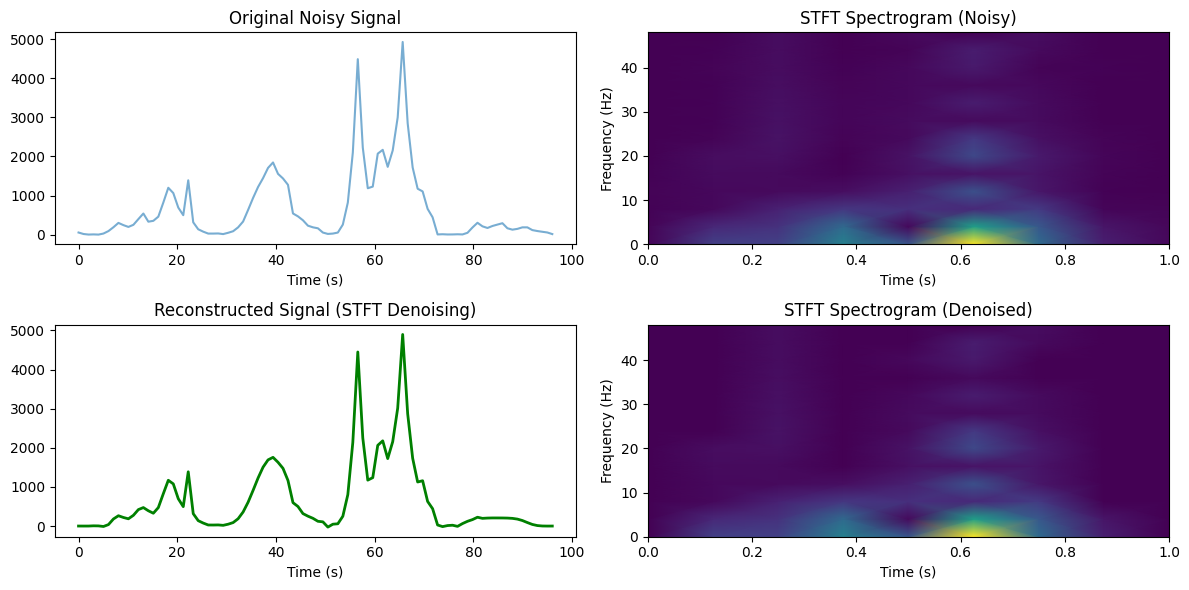

In [6]:
from scipy.signal import stft, istft
import numpy as np


X = np.load('data/sub_UCR_bench/MelbournePedestrian/sample_2/X_test.npy')
# data = np.concatenate([X[0].copy(), X[1].copy(), X[2].copy(), X[3].copy()], axis=1).reshape(96,)
data = np.concatenate([X[5].copy(), X[10].copy(), X[7].copy(), X[4].copy()], axis=1).reshape(96,)
data.shape

# Generate noisy signal (3 Hz + 8 Hz + noise)
np.random.seed(0)
# t = np.linspace(0, 1, 1000)
# x_clean = np.sin(2 * np.pi * 3 * t) + 0.5 * np.sin(2 * np.pi * 8 * t)

x_noisy = data.copy() #x_clean + 0.5 * np.random.randn(len(t))
t = np.linspace(0, x_noisy.shape[0], x_noisy.shape[0])

# Compute STFT
# f, t_spec, Zxx = stft(x_noisy, fs=1000, nperseg=100, noverlap=50, window='hann')
f, t_spec, Zxx = stft(x_noisy, fs=x_noisy.shape[0], nperseg=24, noverlap=12, window='hann')

# Thresholding: Keep only strong frequencies (denoising)
threshold = np.median(np.abs(Zxx))  # Median power as threshold
Zxx_denoised = Zxx * (np.abs(Zxx) > threshold)  # Mask weak components

# Reconstruct signal
# _, x_denoised_stft = istft(Zxx_denoised, fs=1000, nperseg=100, noverlap=50)
_, x_denoised_stft = istft(Zxx_denoised, fs=96, nperseg=24, noverlap=12)


# Plot
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.plot(t, x_noisy, label="Noisy Signal", alpha=0.6)
plt.title("Original Noisy Signal")
plt.xlabel("Time (s)")

plt.subplot(222)
plt.pcolormesh(t_spec, f, np.abs(Zxx), shading='gouraud')
plt.title("STFT Spectrogram (Noisy)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.subplot(223)
plt.plot(t, x_denoised_stft, 'g', label="STFT Denoised", linewidth=2)
plt.title("Reconstructed Signal (STFT Denoising)")
plt.xlabel("Time (s)")

plt.subplot(224)
plt.pcolormesh(t_spec, f, np.abs(Zxx_denoised), shading='gouraud')
plt.title("STFT Spectrogram (Denoised)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

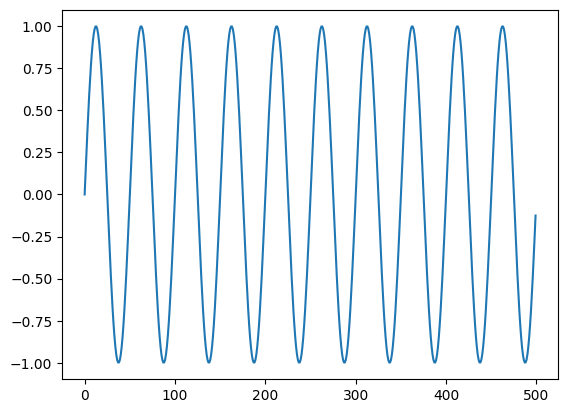

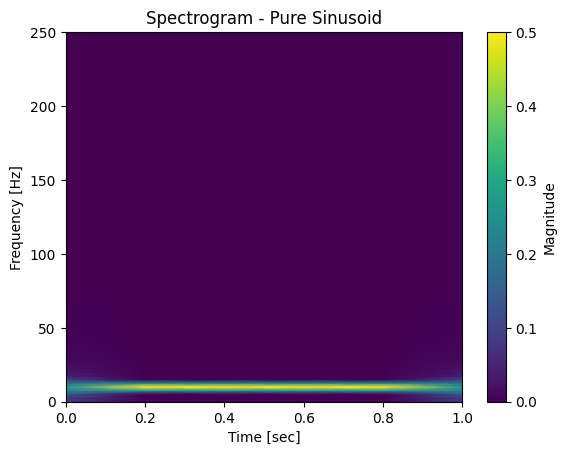

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

fs = 500       # Sampling rate
T = 1            # Duration in seconds
t = np.linspace(0, T, fs*T, endpoint=False)
f0 = 10        # Frequency
x = np.sin(2*np.pi*f0*t)

# Compute STFT
f, t_stft, Zxx = stft(x, fs=fs, nperseg=200)

# Plot
plt.plot(x)
plt.show()
plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Pure Sinusoid')
plt.colorbar(label='Magnitude')
plt.show()

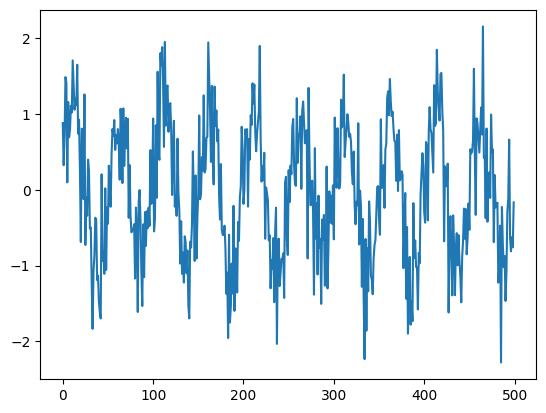

/root/patrec_time_series/.venv/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 512 is greater than input length  = 500, using nperseg = 500
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


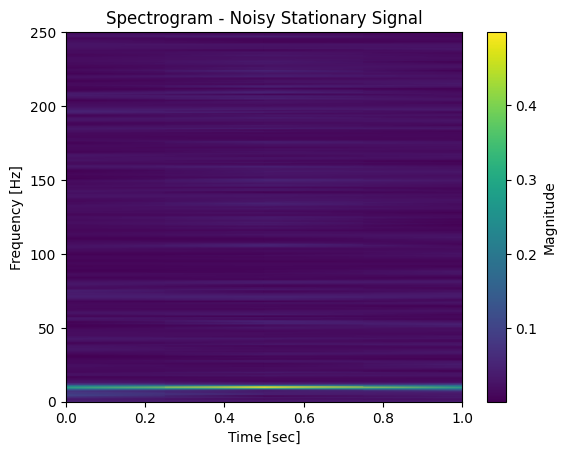

In [8]:
noise = 0.5 * np.random.randn(len(x))
x_noisy = x + noise


plt.plot(x_noisy)
plt.show()
f, t_stft, Zxx = stft(x_noisy, fs=fs, nperseg=512)

plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Noisy Stationary Signal')
plt.colorbar(label='Magnitude')
plt.show()

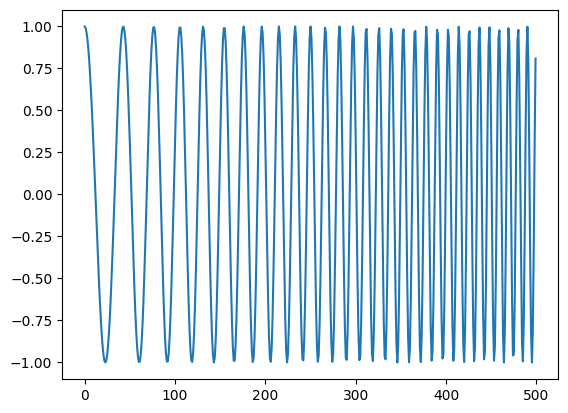

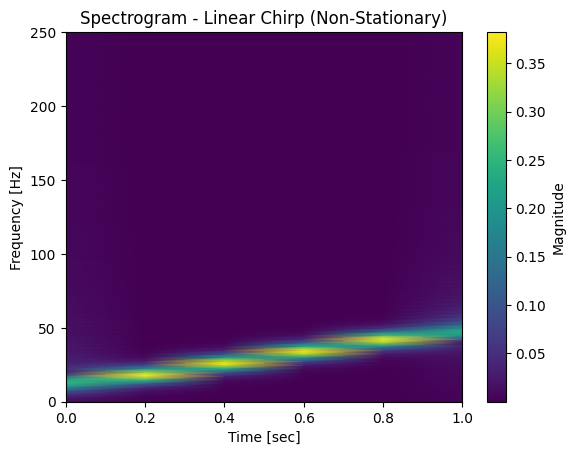

In [9]:
from scipy.signal import chirp, sawtooth, square, gausspulse, chirp, sweep_poly, unit_impulse

x_chirp = chirp(t, f0=10, f1=50, t1=T, method='linear')

frequencies, times, Zxx = stft(x_chirp, fs=fs, nperseg=200)


plt.plot(x_chirp)
plt.show()
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Linear Chirp (Non-Stationary)')
plt.colorbar(label='Magnitude')
plt.show()

In [10]:
power_spectrogram = np.abs(Zxx)**2
power_spectrogram_db = 10 * np.log10(power_spectrogram + 1e-10)  # avoid log(0)

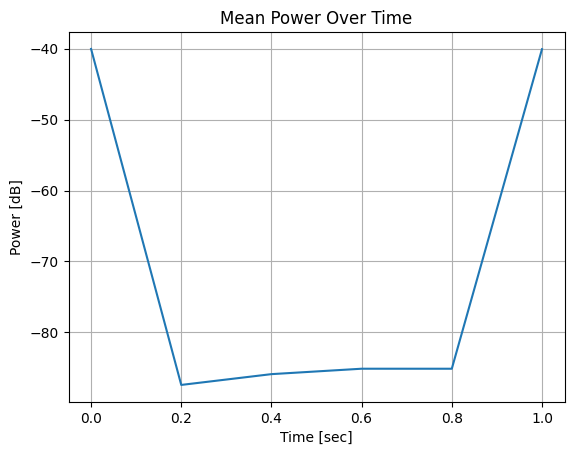

In [11]:
mean_power_over_time = np.mean(power_spectrogram_db, axis=0)
plt.plot(times, mean_power_over_time)
plt.title("Mean Power Over Time")
plt.xlabel("Time [sec]")
plt.ylabel("Power [dB]")
plt.grid()
plt.show()

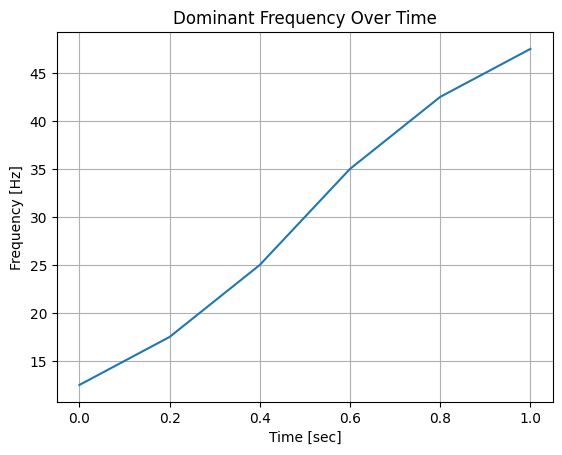

In [12]:
dominant_freq_indices = np.argmax(power_spectrogram_db, axis=0)
dominant_frequencies = frequencies[dominant_freq_indices]

plt.plot(times, dominant_frequencies)
plt.title("Dominant Frequency Over Time")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.show()

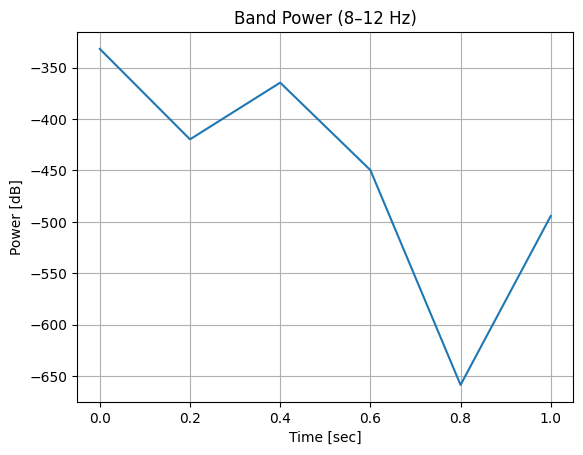

In [13]:
band_mask = (frequencies >= 8) & (frequencies <= 40)
band_power = np.sum(power_spectrogram_db[band_mask, :], axis=0)

plt.plot(times, band_power)
plt.title("Band Power (8–12 Hz)")
plt.xlabel("Time [sec]")
plt.ylabel("Power [dB]")
plt.grid()
plt.show()

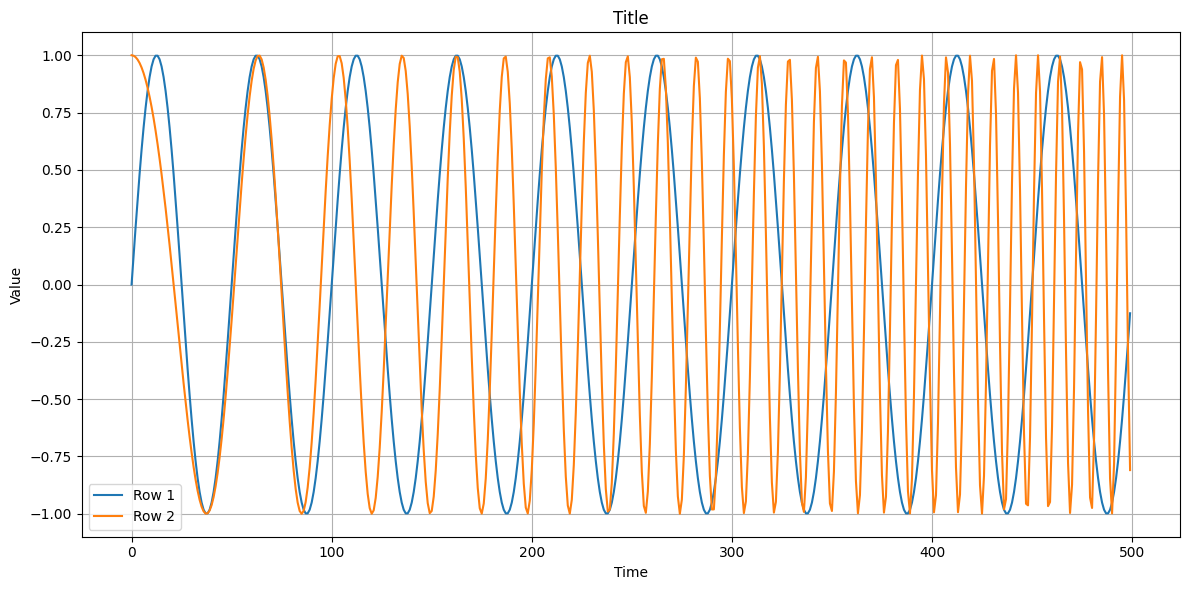

In [14]:
# Signal 1: Sinusoid
x1 = np.sin(2*np.pi*10*t)

# Signal 2: Chirp
x2 = chirp(t, f0=5, f1=50, t1=T, method='linear')

signals = [x1, x2]
labels = ['Sinusoid', 'Chirp']
plot_series([x1,x2])

Cluster labels: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
True labels: ['Sinusoid' 'Sinusoid' 'Sinusoid' 'Sinusoid' 'Sinusoid' 'Sinusoid'
 'Sinusoid' 'Sinusoid' 'Sinusoid' 'Sinusoid' 'Chirp' 'Chirp' 'Chirp'
 'Chirp' 'Chirp' 'Chirp' 'Chirp' 'Chirp' 'Chirp' 'Chirp']


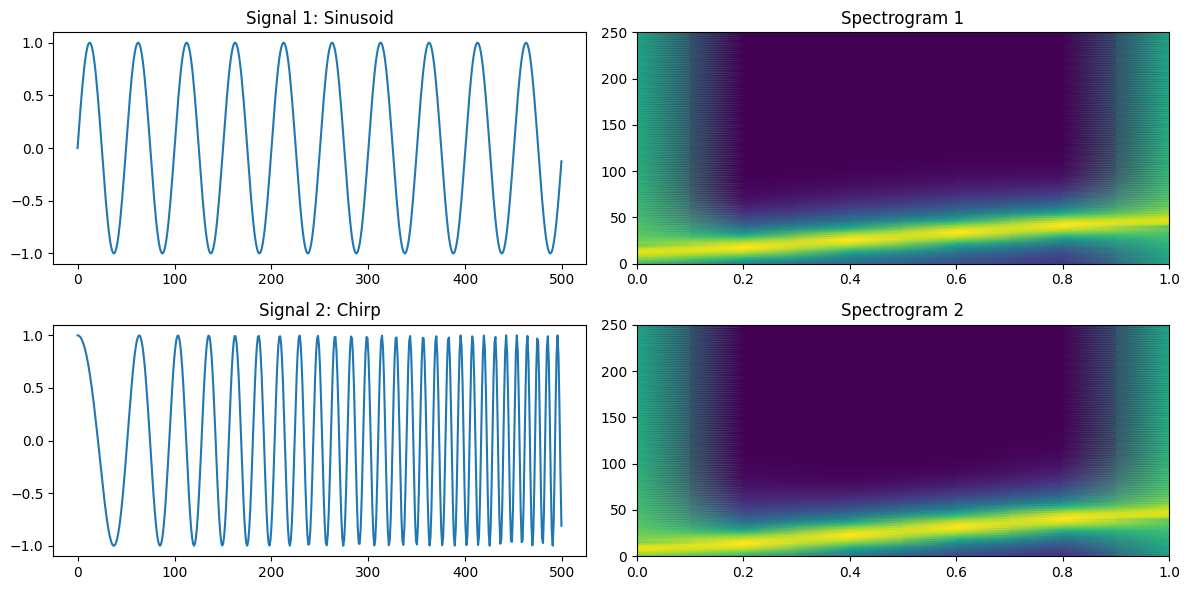

In [15]:
from sklearn.cluster import KMeans

features_list = []

for idx, x_sam in enumerate(signals):
    f, t, Zxx = stft(x_sam, fs=fs, nperseg=200)
    power = 10 * np.log10(np.abs(Zxx)**2 + 1e-10)
    
    # Flatten spectrogram into feature vector
    feature_vector = power.flatten().reshape(1, -1)
    features_list.append(feature_vector)

# Stack features
X = np.vstack(features_list)

# Repeat each label multiple times (simulate more data)
X = np.repeat(X, repeats=10, axis=0)
y = np.repeat(labels, repeats=10)

# Add some noise to simulate variation
X += np.random.normal(0, 0.5, size=X.shape)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

print("Cluster labels:", kmeans.labels_)
print("True labels:", y)

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].plot(x1)
axs[0, 0].set_title("Signal 1: Sinusoid")

axs[0, 1].pcolormesh(t, f, power_spectrogram_db, shading='gouraud')
axs[0, 1].set_title("Spectrogram 1")

axs[1, 0].plot(x2)
axs[1, 0].set_title("Signal 2: Chirp")

f2, t2, Zxx2 = stft(x2, fs=fs, nperseg=200)
power2 = 10 * np.log10(np.abs(Zxx2)**2 + 1e-10)

axs[1, 1].pcolormesh(t2, f2, power2, shading='gouraud') # , cmap='inferno'
axs[1, 1].set_title("Spectrogram 2")

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from matplotlib.colors import LogNorm

class STFT_Decomposer:
    def __init__(self, signal, fs=1.0, nperseg=256, noverlap=None, 
                 window='hann', pad_use=True, pad_mode='constant'):
        """
        Initialize STFT decomposer with a signal.
        
        Parameters:
        signal: Input time-series signal
        fs: Sampling frequency
        nperseg: Length of each segment
        noverlap: Number of points to overlap between segments
        window: Window function type
        pad_mode: Padding mode for signal
        """
        self.original_signal = signal.copy()
        self.fs = fs
        self.nperseg = nperseg
        self.noverlap = noverlap if noverlap is not None else nperseg // 2
        self.window = window
        self.pad_mode = pad_mode
        self.pad_use = pad_use
        
        # Apply padding manually if needed
        self.signal = self._pad_signal(signal)

        # Compute STFT
        self.frequencies, self.times, self.Zxx = stft(
            self.signal, fs=self.fs, nperseg=self.nperseg,
            noverlap=self.noverlap, window=self.window, padded=self.pad_use
        )
        
        # Store magnitude and power
        self.magnitude = np.abs(self.Zxx)
        self.power = self.magnitude ** 2

    def _pad_signal(self, signal):
        """Zero-pad signal symmetrically to reduce edge effects"""
        pad_len = self.nperseg // 2
        return np.pad(signal, pad_len, mode=self.pad_mode)

    def get_values(self):
        return {'frequencies':self.frequencies, 'times': self.times, "magnitude": self.magnitude, "power":self.power, "Zxx": self.Zxx}
    
    
    # def plot_spectrogram(self, freq_range=None, time_range=None, log_scale=False, show=True, title="Spectrogram"):
    #     """
    #     Plot spectrogram with optional frequency/time slicing.
    #     """
    #     f = self.frequencies
    #     t = self.times
    #     mag = self.magnitude

    #     if freq_range:
    #         f_mask = (f >= freq_range[0]) & (f <= freq_range[1])
    #         f = f[f_mask]
    #         mag = mag[f_mask, :]

    #     if time_range:
    #         t_mask = (t >= time_range[0]) & (t <= time_range[1])
    #         t = t[t_mask]
    #         mag = mag[:, t_mask]

    #     fig, ax = plt.subplots(figsize=(10, 5))
    #     norm = LogNorm(vmin=mag.min() + 1e-10, vmax=mag.max()) if log_scale else None
    #     c = ax.pcolormesh(t, f, mag, shading='gouraud', cmap='inferno', norm=norm)
    #     ax.set_title(title)
    #     ax.set_xlabel("Time [sec]")
    #     ax.set_ylabel("Frequency [Hz]")
    #     fig.colorbar(c, ax=ax, label='Magnitude')
    #     if show:
    #         plt.tight_layout()
    #         plt.show()
    #     return fig, ax

    # def get_dominant_frequencies(self, time_idx=None):
    #     """
    #     Get dominant frequency at each time step or for specific index.
    #     Returns:
    #         Array of dominant frequencies over time (or scalar if time_idx provided)
    #     """
    #     if time_idx is None:
    #         max_indices = np.argmax(self.magnitude, axis=0)
    #         return self.frequencies[max_indices]
    #     else:
    #         max_index = np.argmax(self.magnitude[:, time_idx])
    #         return self.frequencies[max_index]

    # def filter_by_frequency_band(self, low_freq, high_freq):
    #     """
    #     Filter STFT coefficients within a frequency band.
    #     Returns:
    #         Inverse STFT reconstructed signal
    #     """
    #     Zxx_filtered = self.Zxx.copy()
    #     mask = (self.frequencies < low_freq) | (self.frequencies > high_freq)
    #     Zxx_filtered[mask, :] = 0

    #     _, x_recon = self._istft(Zxx_filtered)
    #     return x_recon

    # def filter_by_time_segment(self, start_time, end_time):
    #     """
    #     Filter STFT coefficients within a time range.
    #     Returns:
    #         Inverse STFT reconstructed signal
    #     """
    #     Zxx_filtered = self.Zxx.copy()
    #     mask = (self.times < start_time) | (self.times > end_time)
    #     Zxx_filtered[:, mask] = 0

    #     _, x_recon = self._istft(Zxx_filtered)
    #     return x_recon

    # def filter_by_magnitude_threshold(self, threshold, mode='highpass'):
    #     """
    #     Filter STFT coefficients by magnitude threshold.
    #     """
    #     Zxx_filtered = self.Zxx.copy()
    #     if mode == 'highpass':
    #         Zxx_filtered[self.magnitude < threshold] = 0
    #     elif mode == 'lowpass':
    #         Zxx_filtered[self.magnitude >= threshold] = 0
    #     else:
    #         raise ValueError("Mode must be 'highpass' or 'lowpass'")
        
    #     _, x_recon = self._istft(Zxx_filtered)
    #     return x_recon

    # def _istft(self, Zxx_filtered):
    #     """
    #     Perform inverse STFT and remove padding
    #     """
    #     from scipy.signal import istft
    #     _, x_recon = istft(Zxx_filtered, fs=self.fs, nperseg=self.nperseg,
    #                       noverlap=self.noverlap)
    #     # Remove padding added during initialization
    #     pad_len = self.nperseg // 2
    #     return _, x_recon[pad_len:-pad_len]

    # def plot_frequency_evolution(self, show=True):
    #     """
    #     Plot dominant frequency over time
    #     """
    #     dom_freqs = self.get_dominant_frequencies()
    #     fig, ax = plt.subplots(figsize=(10, 4))
    #     ax.plot(self.times, dom_freqs, label='Dominant Frequency')
    #     ax.set_title("Dominant Frequency Over Time")
    #     ax.set_xlabel("Time [sec]")
    #     ax.set_ylabel("Frequency [Hz]")
    #     ax.grid(True)
    #     if show:
    #         plt.tight_layout()
    #         plt.show()
    #     return fig, ax

    # def plot_component_at_time(self, time_idx, show=True):
    #     """
    #     Plot FFT component at a specific time window
    #     """
    #     fft_slice = self.Zxx[:, time_idx]
    #     freqs = self.frequencies
    #     mags = np.abs(fft_slice)

    #     fig, ax = plt.subplots(figsize=(8, 3))
    #     ax.stem(freqs, mags, linefmt='b-', markerfmt=' ', basefmt=' ')
    #     ax.set_title(f"Frequency Components at t={self.times[time_idx]:.2f}s")
    #     ax.set_xlabel("Frequency [Hz]")
    #     ax.set_ylabel("Magnitude")
    #     if show:
    #         plt.tight_layout()
    #         plt.show()
    #     return fig, ax

In [17]:
def plot_f_comps(pos_freqs, pos_mags, min_freq=None, max_freq=None, x_tick_step=1, show=True):
    """
    Plot frequency components with increased spacing between x-axis points.
    
    Parameters:
        min_freq (float): Minimum frequency to display (default: 0)
        max_freq (float): Maximum frequency to display (default: max of positive frequencies)
        x_tick_step (int or float): Step size for x-axis ticks (in Hz)
        show (bool): Whether to show the plot immediately
    """
    if min_freq is None:
        min_freq = 0
    if max_freq is None:
        max_freq = np.max(pos_freqs)

    fig, ax = plt.subplots(figsize=(12, 3))

    ax.stem(pos_freqs, pos_mags, linefmt='b-', markerfmt=' ', basefmt=' ')

    # Calculate statistics within visible range
    freq_mask = (pos_freqs >= min_freq) & (pos_freqs <= max_freq)
    mean_mag = np.mean(pos_mags[freq_mask])
    median_mag = np.median(pos_mags[freq_mask])

    ax.axhline(mean_mag, color='r', linestyle='--', label=f'Mean [{min_freq}-{max_freq}] = {mean_mag:.2f}')
    ax.axhline(median_mag, color='g', linestyle='--', label=f'Median [{min_freq}-{max_freq}] = {median_mag:.2f}')

    ax.set_title("Frequency Components (Sorted by Significance)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_xlim(min_freq, max_freq)

    # # Set x-axis ticks at specified step intervals
    tick_values = np.arange(0, pos_freqs.shape[0]* x_tick_step, step= x_tick_step)
    ax.set_xticks(tick_values, pos_freqs)

    # Optional: rotate labels for better visibility
    plt.xticks(rotation=90, fontsize=7) 


    if show:
        plt.tight_layout()
        plt.show()
        return None
    return fig, ax


# Spectrograms (STFT)
def create_spectrogram(signal, nperseg=64):
    _, _, Zxx = stft(signal, nperseg=nperseg)
    return np.abs(Zxx)

spectrograms = np.array([create_spectrogram(s) for s in signals])

def get_dominant_frequencies_stft(signal, nperseg=64, time_point=0.5, n_top=3):
    f, t, Zxx = stft(signal, nperseg=nperseg)
    time_idx = np.argmin(np.abs(t - time_point))
    magnitudes = np.abs(Zxx[:, time_idx])
    
    # Get top `n_top` frequencies
    top_freq_indices = np.argsort(magnitudes)[-n_top:][::-1]
    top_frequencies = f[top_freq_indices]
    top_magnitudes = magnitudes[top_freq_indices]
    
    return top_frequencies, top_magnitudes

# Example usage
freqs, mags = get_dominant_frequencies_stft(signals[0], time_point=0.5)
print(f"Top frequencies at t=0.5s: {freqs} Hz")
print(f"Magnitudes: {mags}")

Top frequencies at t=0.5s: [0.       0.015625 0.03125 ] Hz
Magnitudes: [0.31897039 0.28464181 0.19613709]


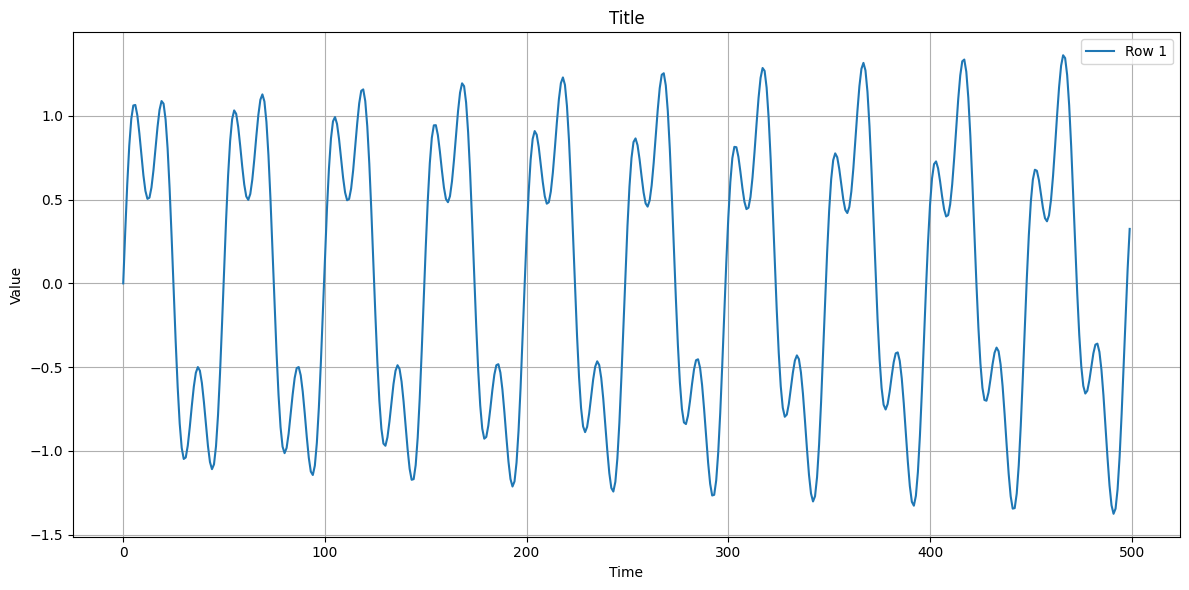

In [18]:
fs = 500
T = 1
t = np.linspace(0, T, fs*T, endpoint=False)
x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*30*t + 1.5*t)

# Initialize decomposer
stftd = STFT_Decomposer(x, fs=fs, nperseg=128, noverlap=45, pad_use=True)

plot_series(x)

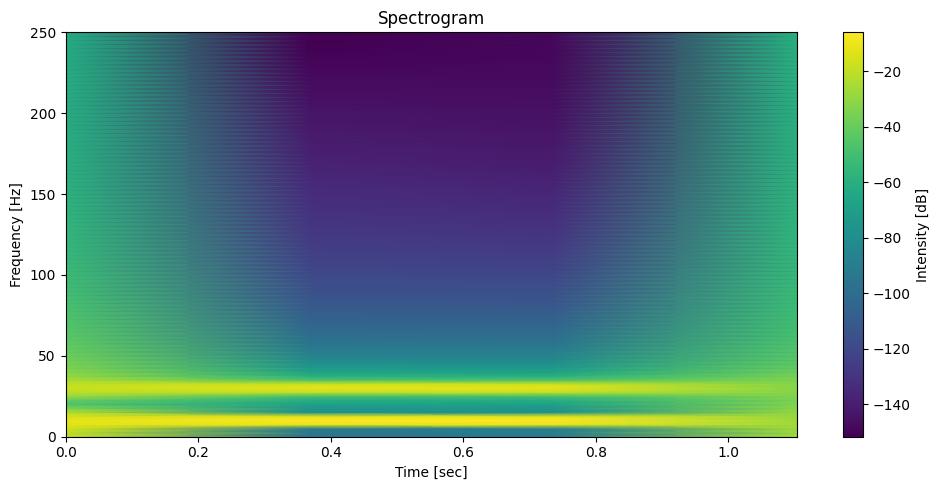

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

fs = 500
T = 1
t = np.linspace(0, T, fs*T, endpoint=False)
x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*30*t + 1.5*t)

# STFT parameters
window = 'hann'
nperseg = 200
noverlap = 16

# Compute STFT
f, t_stft, Zxx = stft(x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

mag_spectrogram = np.abs(Zxx)**2
log_spectrogram = 10 * np.log10(mag_spectrogram)
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_stft, f, log_spectrogram, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()

nperseg=64, Zxx.shape = (33, 17) (freqs x times)


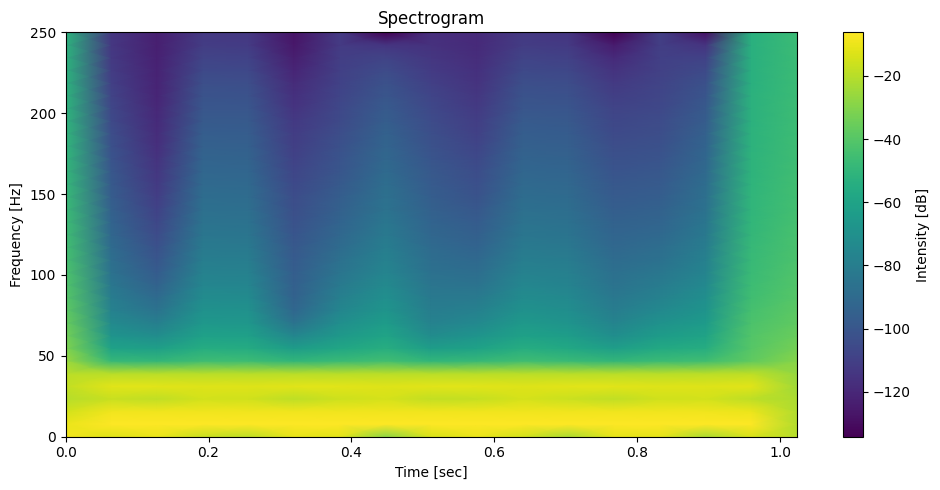

nperseg=128, Zxx.shape = (65, 9) (freqs x times)


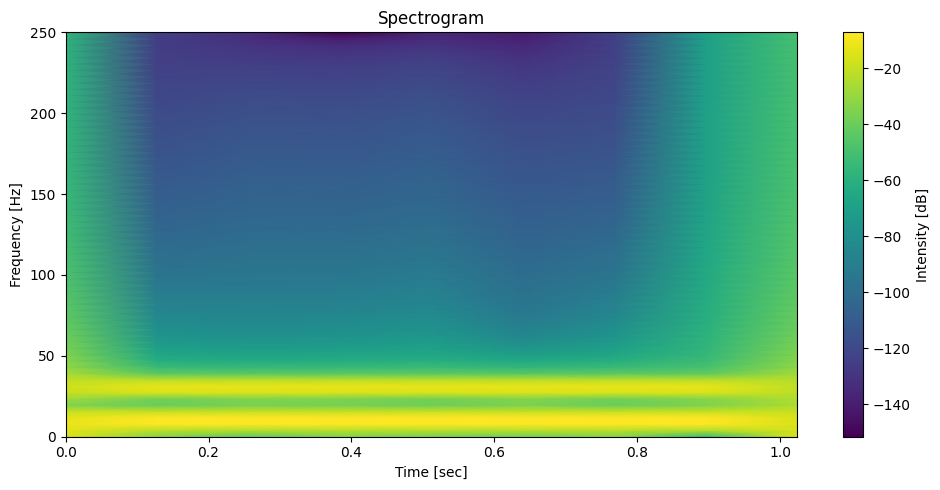

nperseg=256, Zxx.shape = (129, 5) (freqs x times)


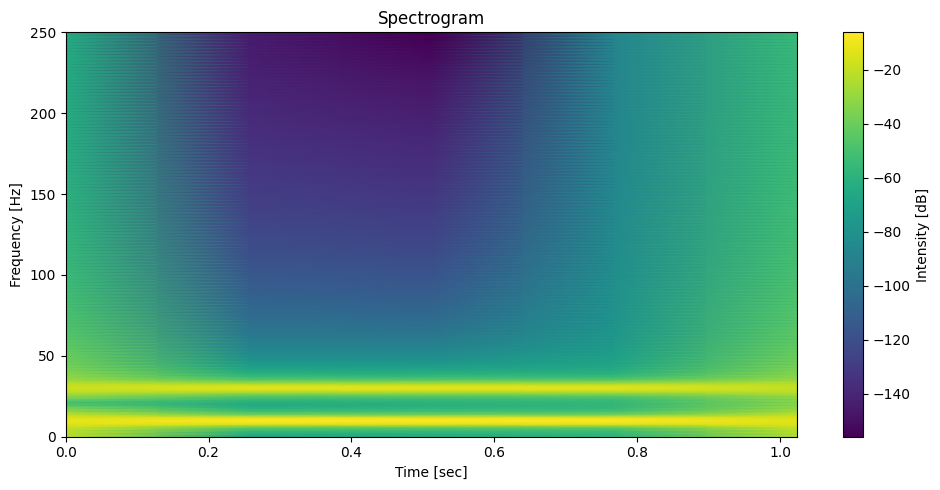

In [24]:
from scipy.signal import stft

# Your signal
fs = 500
T = 1
t = np.linspace(0, T, fs*T, endpoint=False)
x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*30*t + 1.5*t)

# Try different nperseg values
for nperseg in [64, 128, 256]:
    f, t_stft, Zxx = stft(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    print(f'nperseg={nperseg}, Zxx.shape = {Zxx.shape} (freqs x times)')
    
    mag_spectrogram = np.abs(Zxx)**2
    log_spectrogram = 10 * np.log10(mag_spectrogram)
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t_stft, f, log_spectrogram, shading='gouraud')
    plt.title('Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.tight_layout()
    plt.show()

In [27]:
np.abs(Zxx).shape

(129, 5)

In [ ]:
# stftd.frequencies, stftd.times
timepoint = 0.2
n_top = 3

time_idx = np.argmin(np.abs(stftd.times - timepoint))
print(time_idx)
magnitudes = stftd.magnitude[:, time_idx]

# Get top `n_top` frequencies
top_freq_indices = np.argsort(magnitudes)[-n_top:][::-1]
top_frequencies = stftd.frequencies[top_freq_indices]
top_magnitudes = magnitudes[top_freq_indices]

top_frequencies, top_magnitudes

In [ ]:
plot_f_comps(stftd.frequencies, np.abs(stftd.Zxx[:,2]), x_tick_step=4)

In [ ]:
def trim_to_match_length(recon, target):
    """Trims `recon` to the length of `target`, center-aligned."""
    diff = len(recon) - len(target)
    if diff < 0:
        return recon
    start = diff // 2
    end = len(recon) - (diff - start)
    return recon[start:end]

Zxx_filtered = stftd.Zxx * (stftd.magnitude > 0.01)

# Inverse STFT
_, x_reconstructed = istft(Zxx_filtered, nperseg=128, noverlap=45, window='hann')
plot_series([x, x_reconstructed])
plot_series([x, trim_to_match_length(x_reconstructed, x)])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft

def trim_to_match_length(recon, target):
    """Trims `recon` to match the length of `target`, center-aligned."""
    diff = len(recon) - len(target)
    if diff < 0:
        return recon
    start = diff // 2
    end = len(recon) - (diff - start)
    return recon[start:end]

# Parameters
fs = 500
T = 1
t = np.linspace(0, T, fs*T, endpoint=False)
x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*30*t + 1.5*t)

# Initialize decomposer
nperseg = 128
noverlap = 45
window = 'hann'

# Compute STFT without padding
frequencies, times, Zxx = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, padded=False, window=window)

# Filter STFT (e.g., thresholding)
threshold = 0.1
Zxx_filtered = Zxx * (np.abs(Zxx) > threshold)

# Reconstruct
_, x_reconstructed = istft(Zxx_filtered, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)

# Trim reconstructed signal to match original
x_recon_trimmed = trim_to_match_length(x_reconstructed, x)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, label='Original', color='blue')
plt.plot(x_recon_trimmed, label='Reconstructed', color='orange')
plt.title("Aligned Signals")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Sample
# fs = 500
# T = 1
# t = np.linspace(0, T, fs*T, endpoint=False)
# x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*30*t + 1.5*t)

# plot_series([x])
fs = 96
T = 1
X = np.load('data/sub_UCR_bench/MelbournePedestrian/sample_2/X_test.npy')
data = np.concatenate([X[0].copy(), X[1].copy(), X[2].copy(), X[3].copy()], axis=1).reshape(96,)
# data = np.concatenate([X[5].copy(), X[10].copy(), X[7].copy(), X[4].copy()], axis=1).reshape(96,)
x = data.copy()
t = np.linspace(0, T, fs*T, endpoint=False)

# Maybe we can get significant frequencies by some softmax-inspired algorithm that will decrease spectrogram size.


# Initialize STFT Decomposer
stftd = STFT_Decomposer(x, fs=fs, nperseg=40, noverlap=0)

# # 1. Plot full spectrogram
# stftd.plot_spectrogram()

# # 2. Plot frequency evolution
# stftd.plot_frequency_evolution()

# # 3. Plot single time slice
# # stftd.plot_component_at_time(time_idx=50)

# # 4. Filter by frequency band
# filtered = stftd.filter_by_frequency_band(30, 40)
# plt.plot(x, label='Original')
# plt.plot(filtered, label='Band-filtered (25–35 Hz)')
# plt.legend()
# plt.show()

In [ ]:
# stftd.power.shape
# stftd.Zxx[0,43]
result_dict = stftd.get_values()
print(result_dict['Zxx'].shape, result_dict['frequencies'].shape) 
plot_f_comps(result_dict['frequencies'].round(1), np.abs(result_dict['Zxx'][:,1]), x_tick_step=2.5)

# Wavelets 

# ideas

In [ ]:
from statsmodels.tsa.seasonal import STL 

# row_1 = series['Trend + Noise']
# row_1 = series['Seasonal + Drift']
row_1 = series['AR(1) Stationary']

decomp_results = STL(row_1, period = 200).fit()
decomp_results.plot()
plt.show()

data 
(1) -> stationarity & noise \
  -> if noisy + non-stationary must be GP/diffusion \
  -> if non-stationary and not noisy kernels, ruptures seg models \
  -> if stationary + not noisy use MSTL, STL, statistics, kernels, params emb \
  -> use MP for fun (maybe not work) \
(2) -> length & method (learnable, not-learnable) \
  -> if long use MP + Transformer | SSL \
  -> if med use overlap windows + SSL \
(3) -> check WaveNet, Fedformer, Autoformer and so on (correlation Attention) \
  -> find lib and use
  

## Clustering with methods

In [ ]:
coefficients.shape, t.shape, frequencies.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import stft
import pywt

np.random.seed(42)
t = np.linspace(0, 1, 1000)
n_signals = 150  # 50 per class
signals = []
ground_truth = []  # 0=chirp, 1=spike, 2=noisy_sine

# Class 0: Chirp (frequency sweeps 5Hz -> 20Hz)
for _ in range(n_signals // 3):
    chirp = np.sin(2 * np.pi * (5 + 15 * t) * t)
    chirp += 0.2 * np.random.randn(len(t))  # Add noise
    signals.append(chirp)
    ground_truth.append(0)

# Class 1: Spike (transient at random position)
for _ in range(n_signals // 3):
    spike = np.zeros(len(t))
    spike[np.random.randint(100, 900)] = 10  # Random spike
    spike += 0.3 * np.random.randn(len(t))  # Add noise
    signals.append(spike)
    ground_truth.append(1)

# Class 2: Noisy Sine (10Hz + noise)
for _ in range(n_signals // 3):
    sine = np.sin(2 * np.pi * 10 * t)
    sine += 0.5 * np.random.randn(len(t))  # Heavy noise
    signals.append(sine)
    ground_truth.append(2)

signals = np.array(signals)
ground_truth = np.array(ground_truth)

In [ ]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(t, signals[ground_truth == i][0], label=f'Class {i}')
    plt.title(f"Class {i}: {'Chirp' if i==0 else 'Spike' if i==1 else 'Noisy Sine'}")
    plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

def extract_stft_features(signal, nperseg=64):
    _, _, Zxx = stft(signal, nperseg=nperseg)
    return np.abs(Zxx).flatten()  # Flatten spectrogram

X_spectrogram = np.array([extract_stft_features(s) for s in signals])
X_spectrogram_pca = PCA(n_components=2).fit_transform(X_spectrogram)

In [ ]:
def extract_scalogram_features(signal, scales=np.arange(1, 30)):
    coeffs, _ = pywt.cwt(signal, scales, 'morl')
    return np.abs(coeffs).flatten()

X_scalogram = np.array([extract_scalogram_features(s) for s in signals])
X_scalogram_pca = PCA(n_components=2).fit_transform(X_scalogram)

In [ ]:
kmeans_spectrogram = KMeans(n_clusters=3).fit(X_spectrogram)
pred_spectrogram = kmeans_spectrogram.labels_

In [ ]:
kmeans_scalogram = KMeans(n_clusters=3).fit(X_scalogram)
pred_scalogram = kmeans_scalogram.labels_

In [ ]:
plt.figure(figsize=(12, 5))

# Spectrogram Clustering
plt.subplot(121)
plt.scatter(X_spectrogram_pca[:, 0], X_spectrogram_pca[:, 1], 
            c=pred_spectrogram, alpha=0.6)
plt.title("Clustering (STFT Features)")

# Scalogram Clustering
plt.subplot(122)
plt.scatter(X_scalogram_pca[:, 0], X_scalogram_pca[:, 1], 
            c=pred_scalogram, alpha=0.6)
plt.title("Clustering (Wavelet Features)")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Spectrogram accuracy
score_stft = adjusted_rand_score(ground_truth, pred_spectrogram)

# Scalogram accuracy
score_wavelet = adjusted_rand_score(ground_truth, pred_scalogram)

print(f"STFT Clustering Accuracy (ARI): {score_stft:.2f}")
print(f"Wavelet Clustering Accuracy (ARI): {score_wavelet:.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pywt
from scipy.signal import stft

# Generate synthetic signals (same as before)
np.random.seed(42)
t = np.linspace(0, 1, 1000)
n_signals = 150
signals = []
ground_truth = []  # 0=chirp, 1=spike, 2=noisy_sine

# Class 0: Chirp
for _ in range(n_signals // 3):
    chirp = np.sin(2 * np.pi * (5 + 15 * t) * t)
    chirp += 0.2 * np.random.randn(len(t))
    signals.append(chirp)
    ground_truth.append(0)

# Class 1: Spike
for _ in range(n_signals // 3):
    spike = np.zeros(len(t))
    spike[np.random.randint(100, 900)] = 10
    spike += 0.3 * np.random.randn(len(t))
    signals.append(spike)
    ground_truth.append(1)

# Class 2: Noisy Sine
for _ in range(n_signals // 3):
    sine = np.sin(2 * np.pi * 10 * t)
    sine += 0.5 * np.random.randn(len(t))
    signals.append(sine)
    ground_truth.append(2)

signals = np.array(signals)
ground_truth = np.array(ground_truth)

In [ ]:
# Spectrograms (STFT)
def create_spectrogram(signal, nperseg=64):
    _, _, Zxx = stft(signal, nperseg=nperseg)
    return np.abs(Zxx)

# Scalograms (Wavelet)
def create_scalogram(signal, scales=np.arange(1, 30)):
    coeffs, _ = pywt.cwt(signal, scales, 'morl')
    return np.abs(coeffs)

spectrograms = np.array([create_spectrogram(s) for s in signals])
scalograms = np.array([create_scalogram(s) for s in signals])

# Reshape for PyTorch (N, C, H, W)
spectrograms = spectrograms[:, np.newaxis, :, :]  # (N, 1, freq_bins, time_steps)
scalograms = scalograms[:, np.newaxis, :, :]      # (N, 1, scales, time_steps)

# Split into train/test
X_train_spec, X_test_spec, y_train, y_test = train_test_split(
    spectrograms, ground_truth, test_size=0.2, random_state=42
)
X_train_scalo, X_test_scalo, _, _ = train_test_split(
    scalograms, ground_truth, test_size=0.2, random_state=42
)

In [ ]:
import numpy as np
from scipy.signal import stft, istft

def reconstruct_with_significant_stft(signal, nperseg=64, top_percentile=95):
    # Compute STFT
    f, t, Zxx = stft(signal, nperseg=nperseg)
    
    # Threshold: Keep top `top_percentile`% of magnitudes
    magnitude = np.abs(Zxx)
    threshold = np.percentile(magnitude, top_percentile)
    Zxx_filtered = Zxx * (magnitude > threshold)
    
    # Inverse STFT
    _, x_reconstructed = istft(Zxx_filtered, nperseg=nperseg)
    return x_reconstructed[:len(signal)]  # Trim to original length

# Example usage
reconstructed_signal = reconstruct_with_significant_stft(signals[0], top_percentile=95)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t, signals[0], label="Original")
plt.plot(t, reconstructed_signal, label="Reconstructed (Top 5% Frequencies)")
plt.legend()
plt.title("STFT-Based Reconstruction")
plt.show()

In [ ]:
def get_dominant_frequencies_stft(signal, nperseg=64, time_point=0.5, n_top=3):
    f, t, Zxx = stft(signal, nperseg=nperseg)
    time_idx = np.argmin(np.abs(t - time_point))
    magnitudes = np.abs(Zxx[:, time_idx])
    
    # Get top `n_top` frequencies
    top_freq_indices = np.argsort(magnitudes)[-n_top:][::-1]
    top_frequencies = f[top_freq_indices]
    top_magnitudes = magnitudes[top_freq_indices]
    
    return top_frequencies, top_magnitudes

# Example usage
freqs, mags = get_dominant_frequencies_stft(signals[0], time_point=0.5)
print(f"Top frequencies at t=0.5s: {freqs} Hz")
print(f"Magnitudes: {mags}")

In [ ]:
def get_dominant_scales_cwt(signal, scales=np.arange(1, 50), time_point=0.5, n_top=3):
    coeffs, _ = pywt.cwt(signal, scales, 'morl')
    time_idx = np.argmin(np.abs(np.linspace(0, 1, len(signal)) - time_point))
    magnitudes = np.abs(coeffs[:, time_idx])
    
    # Get top `n_top` scales
    top_scale_indices = np.argsort(magnitudes)[-n_top:][::-1]
    top_scales = scales[top_scale_indices]
    top_magnitudes = magnitudes[top_scale_indices]
    
    return top_scales, top_magnitudes

# Example usage
scales, mags = get_dominant_scales_cwt(signals[0], time_point=0.5)
print(f"Top scales at t=0.5s: {scales}")
print(f"Magnitudes: {mags}")

In [ ]:
timestamps = [0.1, 0.3, 0.5, 0.7, 0.9]  # Example timestamps (in seconds)

In [ ]:
def get_top_frequencies_at_timestamps(signal, timestamps, nperseg=64, n_top=3):
    f, t, Zxx = stft(signal, nperseg=nperseg)
    top_freqs = {}
    for ts in timestamps:
        time_idx = np.argmin(np.abs(t - ts))
        magnitudes = np.abs(Zxx[:, time_idx])
        top_freq_indices = np.argsort(magnitudes)[-n_top:][::-1]
        top_freqs[ts] = {
            'frequencies': f[top_freq_indices],
            'magnitudes': magnitudes[top_freq_indices]
        }
    return top_freqs

top_freqs_stft = get_top_frequencies_at_timestamps(signals[0], timestamps)

In [ ]:
def reconstruct_around_timestamps_stft(signal, timestamps, nperseg=64, window_size=0.1):
    reconstructions = {}
    for ts in timestamps:
        # Extract segment around timestamp
        start_idx = int(max(0, (ts - window_size/2) * len(signal)))
        end_idx = int(min(len(signal), (ts + window_size/2) * len(signal)))
        segment = signal[start_idx:end_idx]
        
        # Reconstruct segment using top frequencies
        reconstructed_segment = reconstruct_with_significant_stft(segment, nperseg=nperseg)
        reconstructions[ts] = {
            'original': segment,
            'reconstructed': reconstructed_segment
        }
    return reconstructions

reconstructions_stft = reconstruct_around_timestamps_stft(signals[0], timestamps)

In [ ]:
def get_top_scales_at_timestamps(signal, timestamps, scales=np.arange(1, 30), n_top=3):
    coeffs, _ = pywt.cwt(signal, scales, 'morl')
    top_scales = {}
    for ts in timestamps:
        time_idx = int(ts * len(signal))
        magnitudes = np.abs(coeffs[:, time_idx])
        top_scale_indices = np.argsort(magnitudes)[-n_top:][::-1]
        top_scales[ts] = {
            'scales': scales[top_scale_indices],
            'magnitudes': magnitudes[top_scale_indices]
        }
    return top_scales

top_scales_wavelet = get_top_scales_at_timestamps(signals[0], timestamps)

In [ ]:
import pywt

def reconstruct_with_significant_dwt(signal, wavelet='db4', top_percentile=95):
    # Decompose signal
    coeffs = pywt.wavedec(signal, wavelet, level=5)
    
    # Threshold coefficients
    coeffs_thresh = [pywt.threshold(c, np.percentile(np.abs(c), top_percentile), 'soft') for c in coeffs]
    
    # Reconstruct
    return pywt.waverec(coeffs_thresh, wavelet)

# Example usage
reconstructed_signal = reconstruct_with_significant_dwt(signals[0], top_percentile=95)

def reconstruct_around_timestamps_wavelet(signal, timestamps, wavelet='db4', window_size=0.1):
    reconstructions = {}
    for ts in timestamps:
        # Extract segment around timestamp
        start_idx = int(max(0, (ts - window_size/2) * len(signal)))
        end_idx = int(min(len(signal), (ts + window_size/2) * len(signal)))
        segment = signal[start_idx:end_idx]
        
        # Reconstruct segment using top scales
        reconstructed_segment = reconstruct_with_significant_dwt(segment, wavelet=wavelet)
        reconstructions[ts] = {
            'original': segment,
            'reconstructed': reconstructed_segment
        }
    return reconstructions

reconstructions_wavelet = reconstruct_around_timestamps_wavelet(signals[0], timestamps)

In [ ]:
plt.figure(figsize=(15, 10))
for i, ts in enumerate(timestamps):
    plt.subplot(5, 1, i+1)
    original = reconstructions_stft[ts]['original']
    reconstructed = reconstructions_stft[ts]['reconstructed']
    time_axis = np.linspace(ts - 0.05, ts + 0.05, len(original))
    plt.plot(time_axis, original, label='Original', linewidth=2)
    plt.plot(time_axis, reconstructed, label='Reconstructed (STFT)', linestyle='--')
    plt.title(f"STFT Reconstruction at t={ts:.2f}s")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
for i, ts in enumerate(timestamps):
    plt.subplot(5, 1, i+1)
    original = reconstructions_wavelet[ts]['original']
    reconstructed = reconstructions_wavelet[ts]['reconstructed']
    time_axis = np.linspace(ts - 0.05, ts + 0.05, len(original))
    plt.plot(time_axis, original, label='Original', linewidth=2)
    plt.plot(time_axis, reconstructed[:101], label='Reconstructed (Wavelet)', linestyle='--')
    plt.title(f"Wavelet Reconstruction at t={ts:.2f}s")
    plt.legend()
plt.tight_layout()
plt.show()